In [1]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cpu')

In [2]:
import cv2

from yolort.utils import (
    cv2_imshow,
    get_image_from_url,
    read_image_to_tensor,
)

In [3]:
from yolort.utils.image_utils import plot_one_box, color_list
from yolort.v5 import load_yolov5_model, letterbox, non_max_suppression, scale_coords

## Prepare image and model weights to test

In [4]:
# img_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/test/assets/zidane.jpg"
img_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/test/assets/zidane.jpg"
img_raw = get_image_from_url(img_path)

path_ultralytics_weights = 'r6yolov5s.pt'

You can download the weight with following methods

```python
torch.hub.download_url_to_file(
    r'https://github.com/ultralytics/yolov5/releases/download/v5.0/r6yolov5s.pt',
    path_ultralytics_weights,
    progress=True,
)
```

In [5]:
# Preprocess
img = letterbox(img_raw, new_shape=(640, 640))[0]
img = read_image_to_tensor(img)
img = img.to(device)

## Load model as ultralytics and inference

In [6]:
conf = 0.25
iou = 0.45

model = load_yolov5_model(path_ultralytics_weights, autoshape=False, verbose=True)
model = model.to(device)
model.conf = conf  # confidence threshold (0-1)
model.iou = iou  # NMS IoU threshold (0-1)
model.classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
model.eval()

with torch.no_grad():
    ultralytics_dets = model(img[None])[0]
    ultralytics_dets = non_max_suppression(ultralytics_dets, conf, iou, agnostic=True)[0]


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  yolort.v5.models.common.Conv            [3, 32, 6, 2, 2]              
  1                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  2                -1  1     18816  yolort.v5.models.common.C3              [64, 64, 1]                   
  3                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  4                -1  2    115712  yolort.v5.models.common.C3              [128, 128, 2]                 
  5                -1  1    295424  yolort.v5.models.common.Conv            [128, 256, 3, 2]              
  6                -1  3    625152  yolort.v5.models.common.C3              [256, 256, 3]                 
  7                -1  1   1180672  yolort.v5.models.common.Conv            [256, 512, 3, 2]              
  8                -1  1   1182720  

In [7]:
print(f'Detection results with ultralytics:\n{ultralytics_dets}')

Detection results with ultralytics:
tensor([[3.75988e+02, 3.47675e+01, 5.74189e+02, 3.70005e+02, 8.75967e-01, 0.00000e+00],
        [5.00493e+01, 1.12659e+02, 5.00566e+02, 3.71366e+02, 5.72353e-01, 0.00000e+00],
        [2.19189e+02, 2.23126e+02, 2.54996e+02, 3.73880e+02, 5.25457e-01, 2.70000e+01]])


## Updating model weights from ultralytics to yolort and inference

In [8]:
from yolort.models.yolo import YOLO

In [9]:
model = YOLO.load_from_yolov5(path_ultralytics_weights, version="r6.0")

model.eval()

with torch.no_grad():
    yolort_dets = model(img[None])


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  yolort.v5.models.common.Conv            [3, 32, 6, 2, 2]              
  1                -1  1     18560  yolort.v5.models.common.Conv            [32, 64, 3, 2]                
  2                -1  1     18816  yolort.v5.models.common.C3              [64, 64, 1]                   
  3                -1  1     73984  yolort.v5.models.common.Conv            [64, 128, 3, 2]               
  4                -1  2    115712  yolort.v5.models.common.C3              [128, 128, 2]                 
  5                -1  1    295424  yolort.v5.models.common.Conv            [128, 256, 3, 2]              
  6                -1  3    625152  yolort.v5.models.common.C3              [256, 256, 3]                 
  7                -1  1   1180672  yolort.v5.models.common.Conv            [256, 512, 3, 2]              
  8                -1  1   1182720  

In [10]:
print(f"Detection boxes with yolort:\n{yolort_dets[0]['boxes']}")

Detection boxes with yolort:
tensor([[375.98813,  34.76750, 574.18909, 370.00452],
        [ 50.04932, 112.65916, 500.56610, 371.36639],
        [219.18900, 223.12579, 254.99594, 373.87964]])


In [11]:
print(f"Detection scores with yolort:\n{yolort_dets[0]['scores']}")

Detection scores with yolort:
tensor([0.87597, 0.57235, 0.52546])


In [12]:
print(f"Detection labels with yolort:\n{yolort_dets[0]['labels']}")

Detection labels with yolort:
tensor([ 0,  0, 27])


## Varify the detection results between yolort and ultralytics

In [13]:
# Testing boxes
torch.testing.assert_allclose(
    yolort_dets[0]['boxes'], ultralytics_dets[:, :4], rtol=1e-05, atol=1e-07)
# Testing scores
torch.testing.assert_allclose(
    yolort_dets[0]['scores'], ultralytics_dets[:, 4], rtol=1e-05, atol=1e-07)
# Testing labels
torch.testing.assert_allclose(
    yolort_dets[0]['labels'], ultralytics_dets[:, 5].to(dtype=torch.int64), rtol=1e-05, atol=1e-07)

print("Exported model has been tested, and the result looks good!")

Exported model has been tested, and the result looks good!


## Detection output visualisation

In [14]:
# Get label names
import requests

# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/master/notebooks/assets/coco.names"
label_path = "https://gitee.com/zhiqwang/yolov5-rt-stack/raw/master/notebooks/assets/coco.names"
response = requests.get(label_path)
names = response.text

LABELS = []

for label in names.strip().split('\n'):
    LABELS.append(label)

COLORS = color_list()

The labels can also be obtained by

```python
from yolort.utils.image_utils import load_names
labels = load_names('./assets/coco.names')
```

Hah, that's the trick to rescale the box correctly

In [15]:
boxes = scale_coords(img.shape[1:], yolort_dets[0]['boxes'], img_raw.shape[:-1])
labels = yolort_dets[0]['labels']

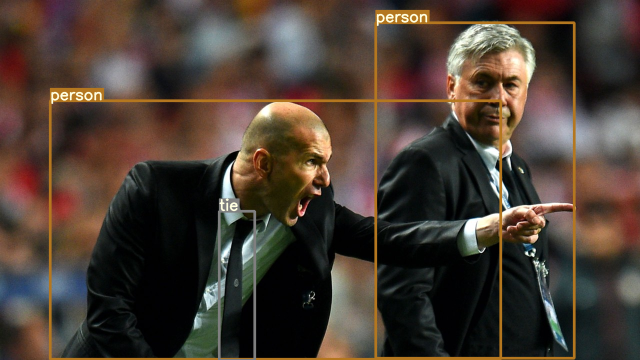

In [16]:
for box, label in zip(boxes.tolist(), labels.tolist()):
    img_raw = plot_one_box(box, img_raw, color=COLORS[label % len(COLORS)], label=LABELS[label])

cv2_imshow(img_raw, imshow_scale=0.5)